# LightGBM의 개요
- XGBoost는 GridSearchCV를 통해 하이퍼 파라미터 튜닝이 오래 걸린다는 단점이 있음
- 그러나 LightGBM은 XGBoost보다 학습시간이 짧고 메모리 사용량도 상대적으로 적음
- 하지만 그렇다고 성능에 저하가 없으며 기능상 다양성도 LightGBM이 더 많다.

<br>

- LightGBM은 리프 중심 트리 분할(Leaf Wise) 방식을 사용함
![image](https://user-images.githubusercontent.com/70187490/131810081-57291d2b-a029-4816-af81-17adcdcd9473.png)


- 기존의 트리 알고리즘은 트리의 깊이를 줄이기 위해 균형 트리 분할(Level Wise)를 사용함
    - 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이를 최소화 할수 있음
    - 이러한 구조의 트리는 과적합에 강하다는 장점을 지니고 있기 때문
    - 그러나 균형을 맞추기 위한 시간이 필요하다는 단점
- LightGBM은 리프 중심 트리 분할(Leaf Wise)방식을 사용함
    - 트리의 균형을 맞추지 않고
    - 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서
    - 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨
    - 카테고리형 피처의 자동 분할과 최적 분할( 원-핫인코딩이 필요하지 않음 )
    - 하지만 자료가 적으면 과적합의 우려가 존재한다.

In [1]:
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['Target']=iris.target

X_features = iris_df.iloc[:,:-1]
y_target = iris_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)
lgb_clf = LGBMClassifier()
lgb_clf.fit(X_train, y_train)
pred = lgb_clf.predict(X_test)

print(accuracy_score(pred, y_test))
print(confusion_matrix(pred, y_test))

1.0
[[ 9  0  0]
 [ 0  9  0]
 [ 0  0 12]]


<AxesSubplot:>

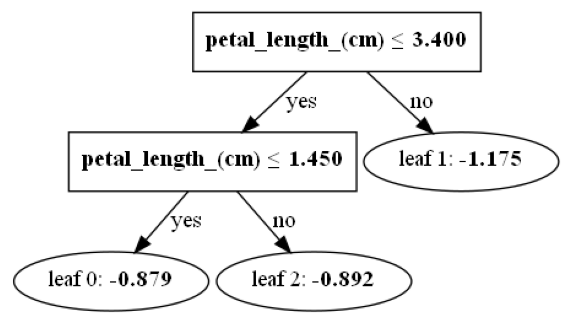

In [2]:
from lightgbm import plot_tree

fig, ax = plt.subplots(figsize=(10, 12))
plot_tree(lgb_clf, ax=ax, orientation='vertical')

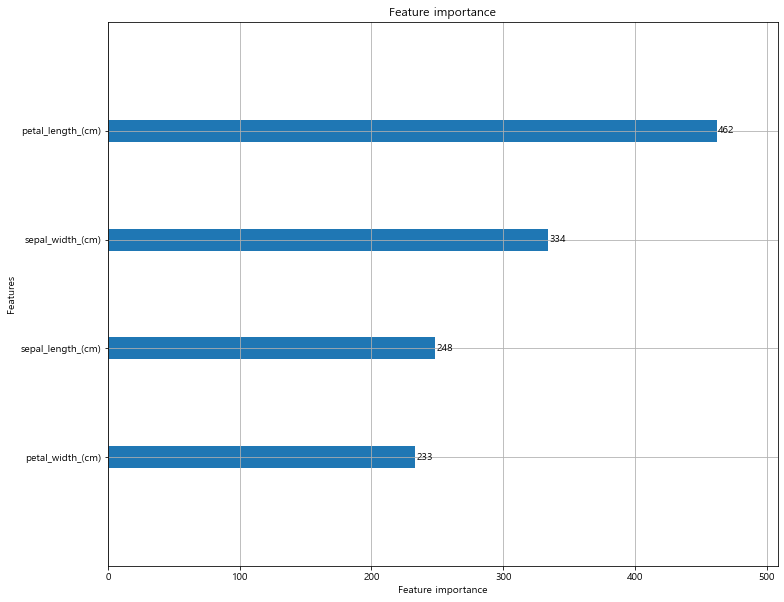

In [3]:
from lightgbm import plot_importance

plot_importance(lgb_clf, figsize=(12, 10));

# Lightgbm 주요 하이퍼 파라미터
![image](https://user-images.githubusercontent.com/70187490/131850406-878d1dc3-231e-436a-a77e-3038f6c07f1c.png)
![image](https://user-images.githubusercontent.com/70187490/131850495-b522bc75-ce02-47c3-af68-852849f45733.png)

## 하이퍼 파라미터 튜닝 방안
num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안  
- **모델 정확도의 향상을 위하여**:
    1. num_leaves: Tree 모델의 복잡성을 컨트롤하는 주요 파라미터. 이상적으로 num_leaves값은 2^(max_depth)값보다 적거나 같아야 함. 이것보다 많은 값은 과적합을 유발
    2. min_data_in_leaf: 큰 값으로 세팅하는 것은 Tree가 너무 깊게 확장하는 것을 막을 수 있지만 under-fitting 언더 피팅이 발생할 수도 있습니다. 
    3. max_depth: Tree 깊이를 명확하게 제한하기 위해 max_depth 값을 설정할 수도 있습니다.
- **더 빠른 속도를 위하여:**
    1. bagging_fraction과 bagging_freq를 설정하여 bagging을 적용하십시오
    2. feature_fraction을 설정하여 feature sub-sampling을 하십시오
    3. 작은 max_bin을 사용하십시오
    4. save_binary 값을 통해 다가오는 학습에서 데이터 로딩 속도를 줄이십시오
    5. parallel learning 병렬 학습을 적용하십시오
- **더 나은 정확도를 위하여:**
    1. 큰 max_bin 값을 사용하십시오( 아마 속도는 느려질겁니다 )
    2. 작은 learning_rate와 큰 num_iterations 값과 함께 사용하십시오
    3. 큰 num_leaves 값을 사용하십시요( 아마 과적합을 유발할 수도 있습니다. )
    4. 더 큰 트레이닝 데이터를 사용하십시오
    5. dart를 사용하십시오
    6. 범주형 feature를 사용하십시오
- **과적합을 해결하기 위해:**
    1. 작은 max_bin 값을 사용하십시오
    2. 작은 num_leaves 값을 사용하십시오
    3. min_data_in_leaf 와 min_sum_hessian_in_leaf 파라미터를 사용하십시오
    4. bagging_fraction 과 bagging_freq 을 사용하여 bagging 을 적용하십시오
    5. feature_fraction을 세팅하여 feature sub-sampling을 하십시오
    6. lambda_l1, lambda_l2 그리고 min_gain_to_split 파라미터를 이용해 regularization (정규화) 를 적용하십시오
    7. max_depth 를 설정해 Deep Tree 가 만들어지는 것을 방지하십시오

In [4]:
def visualize_boundary(estimator, X, y, columns, title=None):
    
    estimator.fit(X, y)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(X[:,0], X[:,1], c=y, cmap='rainbow', edgecolor='k', s=20, zorder=3)
    ax.axis('tight')
    
    x_lim_start, x_lim_end = ax.get_xlim()
    y_lim_start, y_lim_end = ax.get_ylim()
    
    xx, yy = np.meshgrid( np.arange(x_lim_start, x_lim_end, 0.02),
                          np.arange(y_lim_start, y_lim_end, 0.02))
    
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.5, 
                levels = np.arange(len(np.unique(y))+1)-0.5,
                cmap='rainbow');
    
    plt.xlabel(iris.feature_names[columns[0]], fontsize=16)
    plt.ylabel(iris.feature_names[columns[1]], fontsize=16)
    
    if title==None:
        pass
    else:
        plt.title(str(title), fontsize=16)

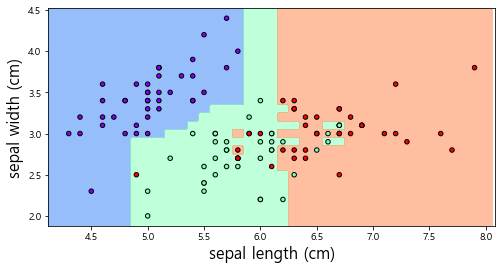

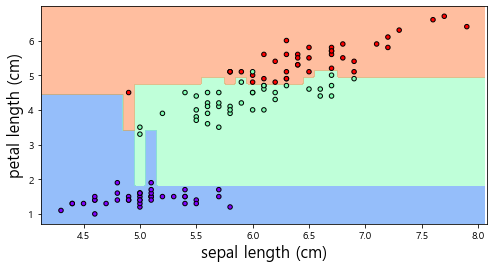

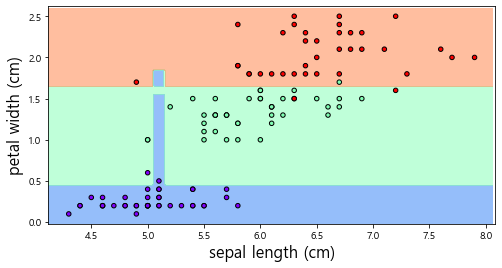

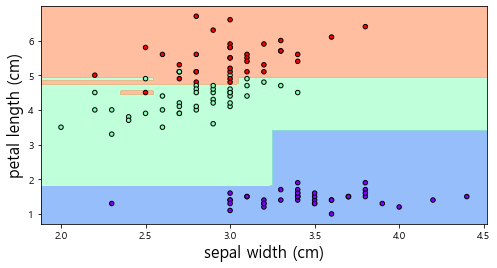

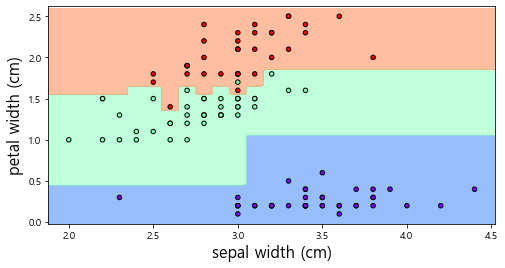

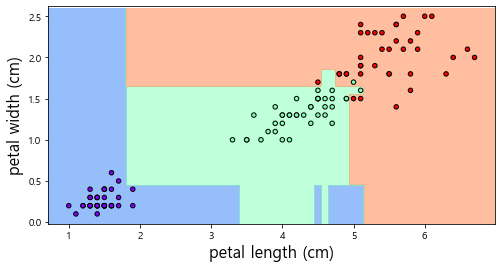

In [5]:
for i in  [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]:
    visualize_boundary(lgb_clf, X_train.to_numpy()[:,i], y_train, i)

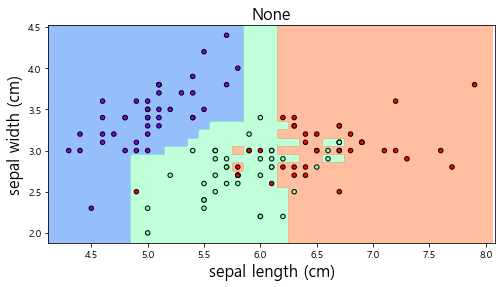

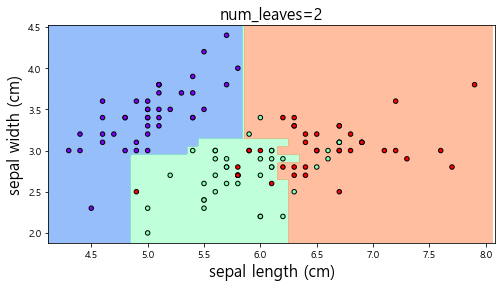

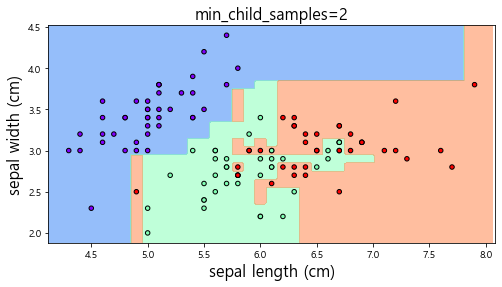

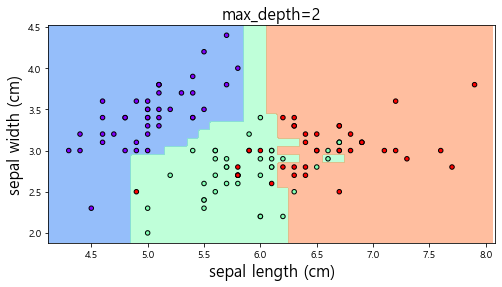

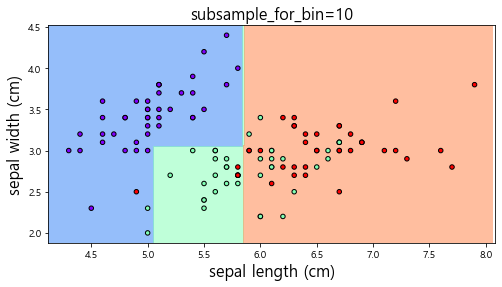

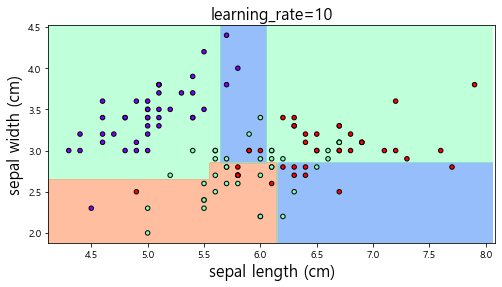

In [6]:
lgb_clf = LGBMClassifier()
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'None')

# num_leaves는 하나의 트리가 가질 수 있는 최대 leaf수다. Default는 31이며 이상적으로는 num_leaves값은 (max_depth)^2보다 적거나 같아야 한다.
lgb_clf = LGBMClassifier(num_leaves=2)
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'num_leaves=2')

# min_chile_samples는 최종 결정 클래스인 leaf가 되기 위해 최소한으로 필요한 레코드의 수.
# Default는 20이며 큰값으로 하면 Tree가 깊게 확장하는 것을 막을 수 있지만 under-fitting이 될 수 있다.
lgb_clf = LGBMClassifier(min_child_samples=2)
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'min_child_samples=2')

# 트리 기반 알고리즘의 max_depth와 같음. 0보다 작은 값을 지정하면 깊이에 제한이 없다.
lgb_clf = LGBMClassifier(max_depth=2)
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'max_depth=2')

# subsample_for_bin은 하나의 bin을 구성하기 위한 샘플수 조정, 큰 값을 주어지면 정확도가 상승하지만 속도가 느려짐
lgb_clf = LGBMClassifier(subsample_for_bin=10)
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'subsample_for_bin=10')

# learning rate는 손실함수의 알파값을 조정하는 학습률. Default는 0.1이며 대부분 0.1~0.01의 수를 사용한다.
# 정확도를 위하여 n_estimators와 함께 조정한다. 크면 클수록 과소적합
lgb_clf = LGBMClassifier(learning_rate=10)
visualize_boundary(lgb_clf, X_train.to_numpy()[:,[0,1]], y_train, [0,1], 'learning_rate=10')

출처: [entheoscientist](https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/)